ARIMA (AutoRegressive Integrated Moving Average) is a powerful model designed to predict future values within a time series dataset. To illustrate its practical application, consider a straightforward implementation of ARIMA in forecasting yearly name frequencies.

In this context, the time series data originates from Retraite Québec, encompassing male first names pertaining to children eligible for family benefits. This dataset encompasses individuals born in Québec or those who have immigrated there since 1980. Through the utilization of ARIMA, we can leverage historical patterns in these name frequencies to make informed predictions about their future trends. This technique is widely used in diverse fields, ranging from economics to demography, offering valuable insights into the behavior of time-dependent data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import rmse
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# data cleaning
df = pd.read_csv('gars1980-2022.csv', header=0)
data = df.dropna()
data = data.drop(index=210077)

In [3]:
# generate time series for a chosen name (WILLIAM)
name = data[data['Prenom_masculin']=='WILLIAM'] 
name = name.drop(columns=['Prenom_masculin', 'Total'])
name = name.T
name.columns = ['count']
name.index.name = 'year'
name.reset_index(inplace=True)
name['year'] = pd.to_datetime(name['year'])
name.set_index('year', inplace=True)
name.tail()

,count
year,
2018-01-01,748
2019-01-01,668
2020-01-01,652
2021-01-01,715
2022-01-01,616


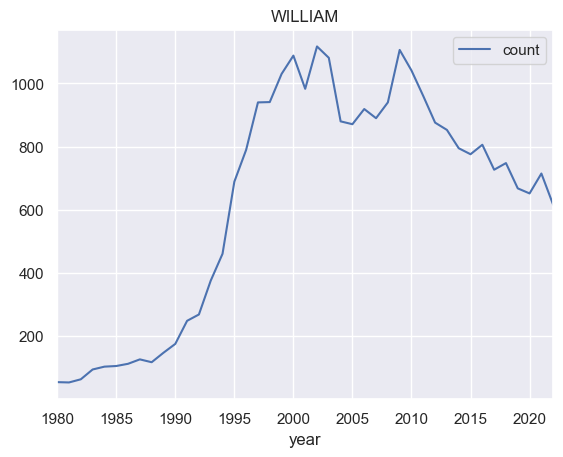

In [4]:
name.plot(title='WILLIAM');

In [5]:
# use auto_arima Grid Search to find the best model parameters
auto_arima(name,seasonal=False,trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=491.484, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=491.834, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=492.121, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=490.633, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=491.945, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.458 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   43
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -244.317
Date:                Tue, 29 Aug 2023   AIC                            490.633
Time:                        16:46:40   BIC                            492.371
Sample:                    01-01-1980   HQIC                           491.270
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6609.6357   1244.289      5.312      0.000    4170.874    9048.397
===================================================================================
Ljung-Box (L1) (Q):                   1.69   Jarque-Bera (JB):                 0.84
Prob(Q):                              0.19   Prob(JB):                         0.66
Heteroskedasticity (H):               2.82   Skew:                             0.14
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [6]:
# train-test set split
train = name[:len(name)-2] 
test = name[len(name)-2:] # use the last 2 years of data as test set

In [7]:
# model fitting using the best parameters suggested by auto_arima (AR =0, I=1, MA=0)
model = ARIMA(train, order=(0,1,0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  count   No. Observations:                   41
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -232.641
Date:                Tue, 29 Aug 2023   AIC                            467.282
Time:                        16:46:40   BIC                            468.970
Sample:                    01-01-1980   HQIC                           467.892
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6596.1900   1241.394      5.314      0.000    4163.102    9029.278
===================================================================================
Ljung-Box (L1) (Q):                   2.32   Jarque-Bera (JB):                 1.15
Prob(Q):                              0.13   Prob(JB):                         0.56
Heteroskedasticity (H):               3.26   Skew:                             0.16
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [8]:
# predict on test set
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels')

In [9]:
# evaluation prediction in terms of error and percentage of error over test mean
print(f"prediction error: {rmse(test['count'], predictions):.2f}")
print(f"prediction error(%): {rmse(test['count'], predictions)/test['count'].mean()*100:.2f}%")

prediction error: 51.31
prediction error(%): 7.71%


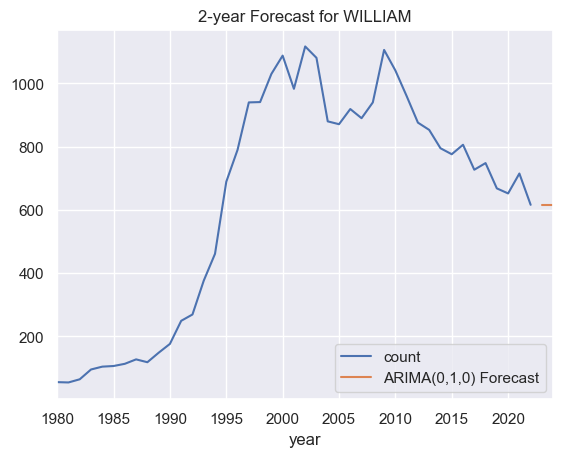

In [10]:
# plot 2-year forecast for WILLIAM
model = ARIMA(name, order=(0,1,0))
results = model.fit() # fit the model on the whole dataset
fcast = results.predict(start=len(name), end=len(name)+1, typ='levels').rename('ARIMA(0,1,0) Forecast')

name.plot(legend=True)
fcast.plot(legend=True)
plt.title('2-year Forecast for WILLIAM');
# set the minimum xticks to be every year from 1980 to 2024;